<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/validation_mount_gdrive/data_ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Ingestion

In [2]:
#@title Imports and modules.
%pip install opencv-python
%pip install matplotlib
%pip install pandas

from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import matplotlib.animation as animation
from matplotlib import rc
from typing import List
from numpy.random import MT19937, RandomState, SeedSequence
import pandas as pd
from tqdm import tqdm
from io import StringIO
import xgboost as xgb
import os
import math
import glob

rc('animation', html='jshtml')

import sys
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
# ddfimport.ddf_source_control_pane()
ddfimport.ddf_import_common()

import dataset
import raster

executing checkout_branch ...
Branch main already checked out.
Remember to reload your imports with `importlib.reload(module)`.
b''
main branch checked out as readonly. You may now use ddf_common imports


## Load dataset

Please select the source of your data to process. Only SAMPLE_CSV_PATH will be used if SAMPLE_SOURCE is set to "GOOGLE DRIVE":

In [ ]:
import ipywidgets as widgets

SAMPLE_SOURCE = "TIMBERID" #@param ["TIMBERID", "GOOGLE DRIVE"]
SAMPLE_CSV_PATH = "" #@param

if SAMPLE_SOURCE == "TIMBERID":
  df = dataset.load_reference_samples()
elif SAMPLE_SOURCE == "GOOGLE DRIVE":
  raster.mount_gdrive()
  df = pd.read_csv(raster.get_sample_db_path(SAMPLE_CSV_PATH), encoding="ISO-8859-1", sep=',')

data = df.columns
checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
output = widgets.VBox(children=checkboxes)
print("Select the features for your model:")
display(output)

Select the features for your model:


In [ ]:
# @title
selected_data = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_data = selected_data + [checkboxes[i].description]
print("Selected features: ", selected_data)
FEATURE_COLUMNS = selected_data

data = df.columns
checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
output = widgets.VBox(children=checkboxes)
print("Select the labels of your model:")
display(output)

Selected features:  ['code', 'd13c_wood', 'mean_annual_precipitation', 'mean_annual_temperature', 'vpd', 'lat', 'long']
Select the labels of your model:


Run the following cell to finalize selecting labels:

In [ ]:
# @title
selected_data = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        assert(checkboxes[i].description not in FEATURE_COLUMNS)
        selected_data = selected_data + [checkboxes[i].description]
print("Selected labels: ", selected_data)
LABEL_COLUMNS = selected_data

Selected labels:  ['d18o_cel']


## Partition Data

Based on the columns available, you'll select the keys by which we'll split your data into training, validation and test splits. This will make sure that there's a single group of measurements in either of the splits, and not an incomplete unit across many partitions.

PARTITION_STRATEGY: The columns that will be used to group the dataset to calculate means and variance on LABEL_COLUMNS. Values can be
- FIXED
- RANDOM

In [ ]:
# @title
PARTITION_STRATEGY = "FIXED" #@param ["FIXED", "RANDOM"] {allow-input:true}

data = FEATURE_COLUMNS
checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
output = widgets.VBox(children=checkboxes)
print("Select the columns to group samples with for partitions:")
display(output)

Select the columns to group samples with for partitions:


KEEP_GROUPING: If True, the rows will remain unique GROUPING_COLUMNS values. Otherwise
we merge the grouping columns aggregates with the original dataset.

In [ ]:
selected_data = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_data = selected_data + [checkboxes[i].description]
print("Selected grouping columns: ", selected_data)
GROUPING_COLUMNS = selected_data

KEEP_GROUPING = True #@param

Selected grouping columns:  ['code', 'lat', 'long']


In [ ]:
# @title
print("This is the configuration you have chosen for pre-processing and partitioning data.\n"
      "Re-run the previous steps again if needed.\n\n")
print("PARTITION_STRATGY: ", PARTITION_STRATEGY)
print("KEEP_GROUPING: ", KEEP_GROUPING)
print("FEATURE_COLUMNS: ", FEATURE_COLUMNS)
print("LABEL_COLUMNS: ", LABEL_COLUMNS)
print("GROUPING_COLUMNS: ", GROUPING_COLUMNS)
print("KEEP_GROUPING: ", KEEP_GROUPING)

This is the configuration you have chosen for pre-processing and partitioning data.
Re-run the previous steps again if needed.


PARTITION_STRATGY:  FIXED
KEEP_GROUPING:  True
FEATURE_COLUMNS:  ['code', 'd13c_wood', 'mean_annual_precipitation', 'mean_annual_temperature', 'vpd', 'lat', 'long']
LABEL_COLUMNS:  ['d18o_cel']
GROUPING_COLUMNS:  ['code', 'lat', 'long']
KEEP_GROUPING:  True


## Pre-Process and Split Data

In [ ]:
# @title Run this cell to pre-process and split data

for column in LABEL_COLUMNS:
  df[column] = df[column].astype(float)

sample_data = dataset.preprocess_sample_data(df, FEATURE_COLUMNS, LABEL_COLUMNS, GROUPING_COLUMNS, KEEP_GROUPING)

partitioned_dataset = None
if PARTITION_STRATEGY == "FIXED":
  partitioned_dataset = dataset.partition(sample_data, dataset.PartitionStrategy.FIXED)
elif PARTITION_STRATEGY == "RANDOM":
  partitioned_dataset = dataset.partition(sample_data, dataset.PartitionStrategy.RANDOM)
else:
  raise ValueError(f"Unknown partition strategy: {PARTITION_STRATEGY}")

train_data = partitioned_dataset.train
validation_data = partitioned_dataset.validation
test_data = partitioned_dataset.test

/tmp/ddf_common/dataset.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped.mean().reset_index()
/tmp/ddf_common/dataset.py:353: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  variances = grouped.var().reset_index()



## (Optional) Visualize data

Rows in training set: 73
Rows in validation set:  40
Rows in test set: 106


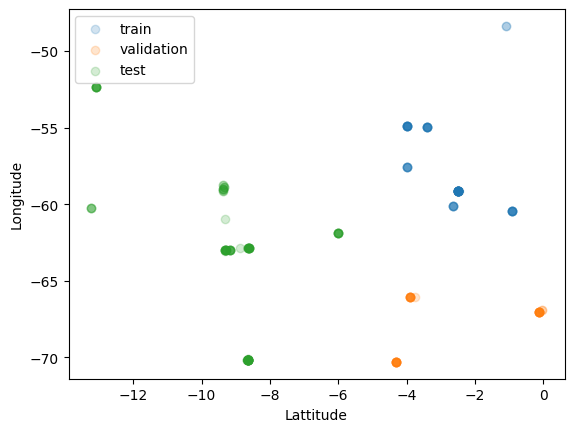

In [ ]:
# @title Run this cell to visualize your partitioned data.
print("Rows in training set:", train_data.shape[0])
print("Rows in validation set: ", validation_data.shape[0])
print("Rows in test set:", test_data.shape[0])

# Optional (plot splits)
import matplotlib
import matplotlib.pyplot as plt

plt.scatter(train_data["lat"], train_data["long"], label="train", alpha=0.2)
plt.scatter(validation_data["lat"], validation_data["long"], label="validation", alpha=0.2)
plt.scatter(test_data["lat"], test_data["long"], label="test", alpha=0.2)
plt.xlabel('Lattitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

## Export processed dataset

In [ ]:
OUTPUT_DATASET_NAME="timberid" #@param
OUTPUT_DATASET_ROOT = "" #@param
GROUPING_STR = "grouped" if KEEP_GROUPING else "ungrouped"

OUTPUT_TRAIN_CSV_PATH = f"{OUTPUT_DATASET_ROOT}{OUTPUT_DATASET_NAME}_train_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"
OUTPUT_VALIDATION_CSV_PATH = f"{OUTPUT_DATASET_ROOT}{OUTPUT_DATASET_NAME}_validation_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"
OUTPUT_TEST_CSV_PATH = f"{OUTPUT_DATASET_ROOT}{OUTPUT_DATASET_NAME}_test_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"

print("OUTPUT_TRAIN_CSV_PATH: ", raster.get_sample_db_path(
    OUTPUT_TRAIN_CSV_PATH))
print("OUTPUT_VALIDATION_CSV_PATH: ", raster.get_sample_db_path(
    OUTPUT_VALIDATION_CSV_PATH))
print("OUTPUT_TEST_CSV_PATH: ", raster.get_sample_db_path(
    OUTPUT_TEST_CSV_PATH))

train_data.to_csv(raster.get_sample_db_path(OUTPUT_TRAIN_CSV_PATH))
validation_data.to_csv(raster.get_sample_db_path(OUTPUT_VALIDATION_CSV_PATH))
test_data.to_csv(raster.get_sample_db_path(OUTPUT_TEST_CSV_PATH))

Mounted at /content/gdrive
OUTPUT_TRAIN_CSV_PATH:  /content/gdrive/MyDrive/amazon_rainforest_files/amazon_sample_data/timberid_train_fixed_grouped.csv
OUTPUT_VALIDATION_CSV_PATH:  /content/gdrive/MyDrive/amazon_rainforest_files/amazon_sample_data/timberid_validation_fixed_grouped.csv
OUTPUT_TEST_CSV_PATH:  /content/gdrive/MyDrive/amazon_rainforest_files/amazon_sample_data/timberid_test_fixed_grouped.csv
